# Dataset — NYC Flights (2013)

Source: Kaggle — “Flights (NYC 2013)”. Each row represents one flight departing from JFK, LGA, or EWR during 2013.
https://www.kaggle.com/datasets/mahoora00135/flights/data
### Typical columns:

Timing: year, month, day, hour, minute, sched_dep_time, sched_arr_time, dep_time, arr_time

Performance: dep_delay (min), arr_delay (min), air_time (min), distance (miles)

IDs / Locations: carrier (airline code), flight (flight number/code), tailnum, origin, dest

Units: delays and air time are in minutes; distance in miles; hours in 0–23.

Quality notes: real-world data includes missing values, outliers (e.g., long delays), and potential data-entry quirks (non-numeric HHMM times).

Project Goal

Understand flight delays and build an actionable, pre-departure view of risk:

Main target: late arrival (e.g., arr_delay ≥ 15 min).

### Constraint:
 use only information known before departure (to avoid leakage). That means we do not use dep_delay, arr_time, or arr_delay as predictors for pre-departure modeling.

## What We Did (Method)

Understanding Data

Verified column meanings and dtypes; converted HHMM fields to minutes since midnight.

Described numeric vs categorical columns (summary stats & cardinalities).

EDA & Insights

# Univariate:
 distributions of arr_delay, dep_delay, distance, air_time.

# Bivariate:

Num vs Cat: arr_delay by carrier and by origin (box/violin).

Num vs Num: arr_delay vs distance (scatter).

# Temporal:
 average dep_delay by hour, late-rate by month.

# Multivariate: 
correlations among numeric features.

Pre-processing

# Duplicates:
 detected and removed if any.

# Missing values:
 imputed appropriately (numeric: median/knn; categorical: most frequent), after isolating the target (rows with missing target are dropped for modeling).

# Encoding rules:

Low-cardinality (e.g., origin) → One-Hot

High-cardinality (e.g., carrier, dest, optionally flight) → Binary encoding

# Outliers:
 inspected (e.g., dep_delay, distance); treated where needed.

#  Train/test split; 
trained a baseline classifier to predict late arrival (≥15m) using pre-departure features only.


# Scaling: 
applied to selected numeric features for model stability.

Reported key metrics (AUC/ROC, precision/recall, calibration) when enabled.

## Dashboard (What You Can Explore)

Box: arr_delay by carrier (minutes)

Line: average dep_delay by hour (minutes)

Histogram: distance distribution (miles)

Scatter: arr_delay vs distance (colored by carrier)

Bar: late-arrival rate by month (%)

Filters (drill-down) above each chart: Month, Day, Carrier/Origin — all charts update instantly.

## 0) Load Data (Robust loader with fallback)

In [1]:

# manpulation
import numpy as np
import pandas as pd

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

# Feature Extraction

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer # text feature

# Pre-Processing
from sklearn.model_selection import train_test_split # train-test-split
from sklearn.impute import SimpleImputer, KNNImputer # detect & handle NaNs
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder, OneHotEncoder # Ordinal Encoding, Nominal Encoding
from category_encoders import BinaryEncoder # Nominal Encoding 

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler # Scaling

In [2]:
import pandas as pd, numpy as np
df= pd.read_csv("Flights export 2025.csv")
df.head()
# id: Unique identifier for each flight record (if present in your file).
# year: Calendar year of the flight (e.g., 2013).
# month: Calendar month of the flight (1–12).
# day: Day of month for the flight.
# dep_time: Actual local departure time in HHMM format (e.g., 517 = 5:17 AM); missing if canceled.
# sched_dep_time: Scheduled local departure time in HHMM format.
# dep_delay: Departure delay in minutes (Actual − Scheduled); negative means left early.
# arr_time: Actual local arrival time in HHMM format; missing if flight didn’t arrive (e.g., canceled/diverted).
# sched_arr_time: Scheduled local arrival time in HHMM format.
# arr_delay: Arrival delay in minutes (Actual − Scheduled); negative means arrived early.
# carrier: Two-letter airline carrier code (IATA), e.g., AA, DL, UA.
# flight: Published flight number assigned by the carrier.
# tailnum: Aircraft registration (tail number) that operated the flight.
# origin: Origin airport code (NYC airports typically JFK, LGA, or EWR).
# dest: Destination airport code (IATA).
# air_time: Minutes spent in the air (wheels-off to wheels-on).
# distance: Great-circle distance between origin and destination (miles).
# hour: Scheduled departure hour (0–23), extracted for convenience.
# minute: Scheduled departure minute (0–59), extracted for convenience.
# time_hour: Combined date+hour timestamp representing the scheduled departure hour (used for time-series grouping).
# name: Full airline carrier name corresponding to the carrier code.


id  year  month  day  dep_time  sched_dep_time  dep_delay  arr_time  \
0   0  2013      1    1     517.0             515        2.0     830.0   
1   1  2013      1    1     533.0             529        4.0     850.0   
2   2  2013      1    1     542.0             540        2.0     923.0   
3   3  2013      1    1     544.0             545       -1.0    1004.0   
4   4  2013      1    1     554.0             600       -6.0     812.0   

   sched_arr_time  arr_delay  ... flight  tailnum origin dest air_time  \
0             819       11.0  ...   1545   N14228    EWR  IAH    227.0   
1             830       20.0  ...   1714   N24211    LGA  IAH    227.0   
2             850       33.0  ...   1141   N619AA    JFK  MIA    160.0   
3            1022      -18.0  ...    725   N804JB    JFK  BQN    183.0   
4             837      -25.0  ...    461   N668DN    LGA  ATL    116.0   

   distance  hour  minute                time_hour                    name  
0      1400     5      15  2013-01-01 05:00:00.000   United Air Lines Inc.  
1      1416     5      29  2013-01-01 05:00:00.000   United Air Lines Inc.  
2      1089     5      40  2013-01-01 05:00:00.000  American Airlines Inc.  
3      1576     5      45  2013-01-01 05:00:00.000         JetBlue Airways  
4       762     6       0  2013-01-01 06:00:00.000    Delta Air Lines Inc.  

[5 rows x 21 columns]

## 1) Understanding Data

In [3]:
df.info()
# Dataset Summary
# ---------------
# • Size: 336,776 rows and 21 columns.
# • Data types:
#   - int64 (integers)
#   - float64 (floating-point numbers)
#   - object (typically strings/categorical)
# • Missing values:
#   Present in the following columns: dep_time, dep_delay, arr_time, arr_delay, tailnum, air_time.
#   This is indicated by fewer non-null entries in these columns than the total row count.


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 336776 entries, 0 to 336775
Data columns (total 21 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   id              336776 non-null  int64  
 1   year            336776 non-null  int64  
 2   month           336776 non-null  int64  
 3   day             336776 non-null  int64  
 4   dep_time        328521 non-null  float64
 5   sched_dep_time  336776 non-null  int64  
 6   dep_delay       328521 non-null  float64
 7   arr_time        328063 non-null  float64
 8   sched_arr_time  336776 non-null  int64  
 9   arr_delay       327346 non-null  float64
 10  carrier         336776 non-null  object 
 11  flight          336776 non-null  int64  
 12  tailnum         334264 non-null  object 
 13  origin          336776 non-null  object 
 14  dest            336776 non-null  object 
 15  air_time        327346 non-null  float64
 16  distance        336776 non-null  int64  
 17  hour      

In [4]:
# Convert 'id' and 'flight' to object data type
df['id'] = df['id'].astype(str)
df['flight'] = df['flight'].astype(str) #This feature represents the designated number of the flight.

In [5]:
#  Understand columns: shape 
df.shape

(336776, 21)

In [6]:
#  Check dtypes 
df.dtypes

id                 object
year                int64
month               int64
day                 int64
dep_time          float64
sched_dep_time      int64
dep_delay         float64
arr_time          float64
sched_arr_time      int64
arr_delay         float64
carrier            object
flight             object
tailnum            object
origin             object
dest               object
air_time          float64
distance            int64
hour                int64
minute              int64
time_hour          object
name               object
dtype: object

In [7]:
# (c) Describe numerical cols
df.describe()
#  notes 
# year: Constant 2013 (std=0.00) → no variance; can be dropped.
# month: Scheduled departure month, 1–12 (std≈3.41) → well spread across the year.
# day: Day of month, 1–31 (std≈8.77) → broadly distributed.
# hour: Scheduled departure hour, 1–23 (std≈4.66) → evenly spread across the day.
# minute: Scheduled departure minute, 0–59 (std≈19.30).
# month, day, hour, minute: Scheduled departure date/time; good range and fairly even distribution.
# dep_time: Actual departure time ,(missing values ) .
# sched_dep_time: Scheduled departure time .
# arr_time: Actual arrival time (HHMM), (missing values ).
# sched_arr_time: Scheduled arrival time .
# dep_delay: TARGET — departure delay (min),  (std≈40.21); negative=early, positive=late.
# arr_delay: TARGET — arrival delay (min),  (std≈44.63); negative=early, positive=late.
# ai# air_time: Flight duration in minutes (≈20–695).
# distance: Origin–destination distance (miles), 17–4983 (std≈733.23).


year          month            day       dep_time  sched_dep_time  \
count  336776.0  336776.000000  336776.000000  328521.000000   336776.000000   
mean     2013.0       6.548510      15.710787    1349.109947     1344.254840   
std         0.0       3.414457       8.768607     488.281791      467.335756   
min      2013.0       1.000000       1.000000       1.000000      106.000000   
25%      2013.0       4.000000       8.000000     907.000000      906.000000   
50%      2013.0       7.000000      16.000000    1401.000000     1359.000000   
75%      2013.0      10.000000      23.000000    1744.000000     1729.000000   
max      2013.0      12.000000      31.000000    2400.000000     2359.000000   

           dep_delay       arr_time  sched_arr_time      arr_delay  \
count  328521.000000  328063.000000   336776.000000  327346.000000   
mean       12.639070    1502.054999     1536.380220       6.895377   
std        40.210061     533.264132      497.457142      44.633292   
min       -43.000000       1.000000        1.000000     -86.000000   
25%        -5.000000    1104.000000     1124.000000     -17.000000   
50%        -2.000000    1535.000000     1556.000000      -5.000000   
75%        11.000000    1940.000000     1945.000000      14.000000   
max      1301.000000    2400.000000     2359.000000    1272.000000   

            air_time       distance           hour         minute  
count  327346.000000  336776.000000  336776.000000  336776.000000  
mean      150.686460    1039.912604      13.180247      26.230100  
std        93.688305     733.233033       4.661316      19.300846  
min        20.000000      17.000000       1.000000       0.000000  
25%        82.000000     502.000000       9.000000       8.000000  
50%       129.000000     872.000000      13.000000      29.000000  
75%       192.000000    1389.000000      17.000000      44.000000  
max       695.000000    4983.000000      23.000000      59.000000

In [8]:
# (d) Describe categorical 
df.describe(include=["object"])
# 🔎 Categorical insights:
# • Carriers (16): Top = UA (United Air Lines Inc.) with 58,665 flights 
# • Tail numbers (4,043 unique): Top = N725MQ (575 flights). 
# • Origins (3), Top = EWR (120,835 flights,) .
# • time_hour This is the scheduled departure time of the flight, represented in local time
#  and formatted as "yyyy-mm-dd hh:mm:ss". There are 6936 unique times in the dataset.
# carrier, name: These are airline carrier codes and names. There are 16 unique carriers in the dataset.
# • flight: Flight numbers (e.g., "UA 1"), 3844 unique.



id carrier  flight tailnum  origin    dest  \
count   336776  336776  336776  334264  336776  336776   
unique  336776      16    3844    4043       3     105   
top          0      UA      15  N725MQ     EWR     ORD   
freq         1   58665     968     575  120835   17283   

                      time_hour                   name  
count                    336776                 336776  
unique                     6936                     16  
top     2013-09-13 08:00:00.000  United Air Lines Inc.  
freq                         94                  58665

In [9]:
df.columns

Index(['id', 'year', 'month', 'day', 'dep_time', 'sched_dep_time', 'dep_delay',
       'arr_time', 'sched_arr_time', 'arr_delay', 'carrier', 'flight',
       'tailnum', 'origin', 'dest', 'air_time', 'distance', 'hour', 'minute',
       'time_hour', 'name'],
      dtype='object')

## 2) EDA — 10 Business Questions  



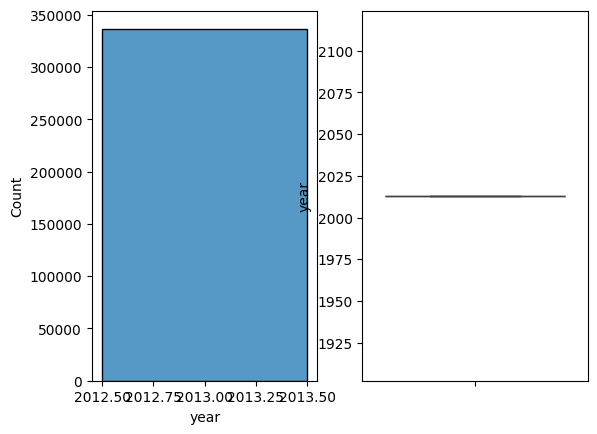

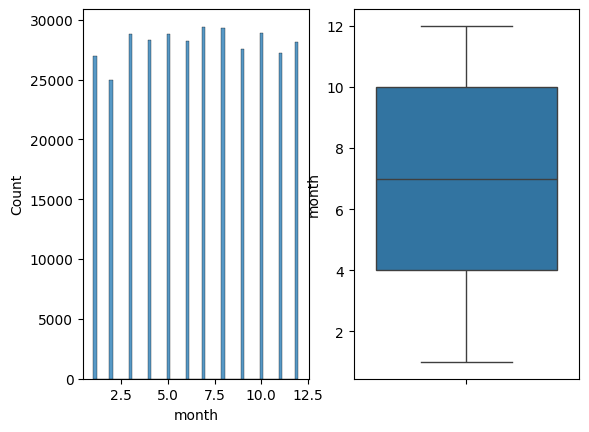

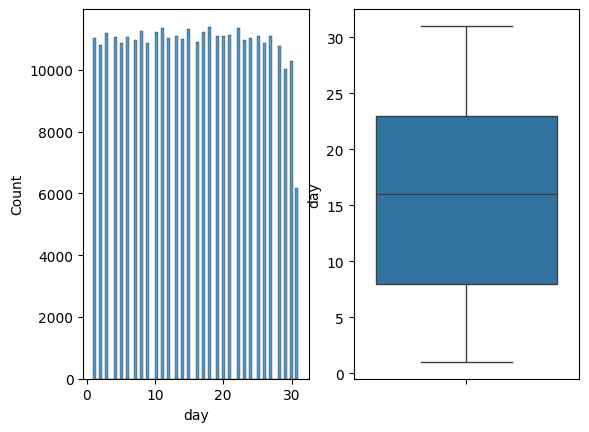

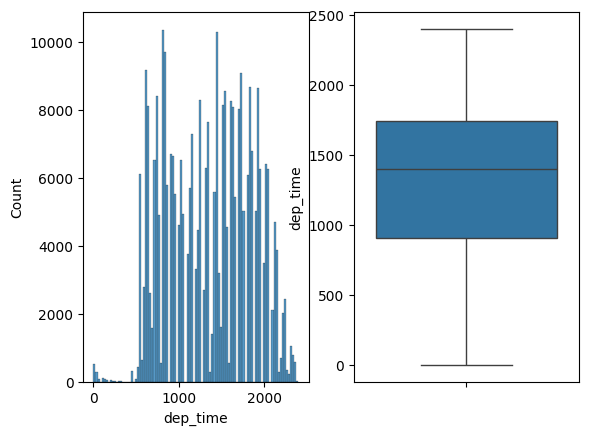

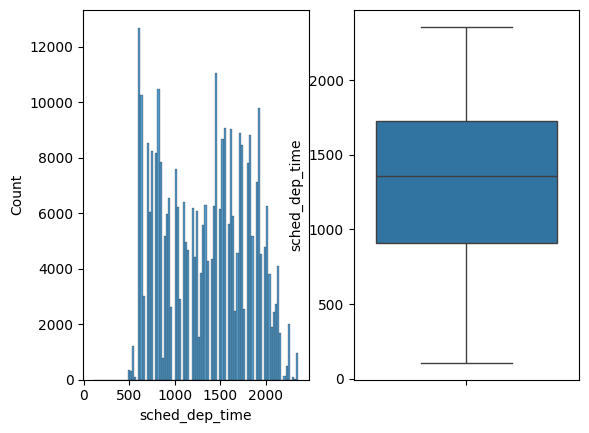

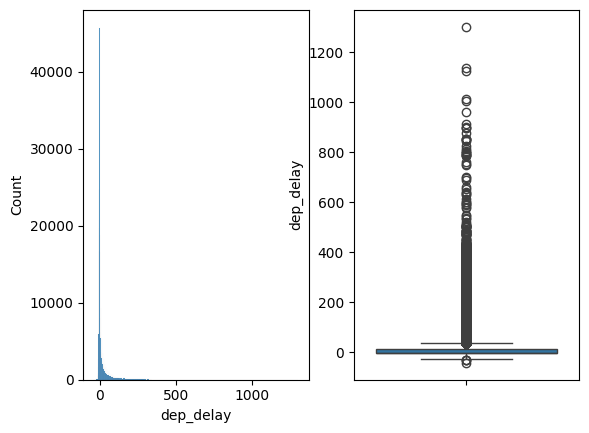

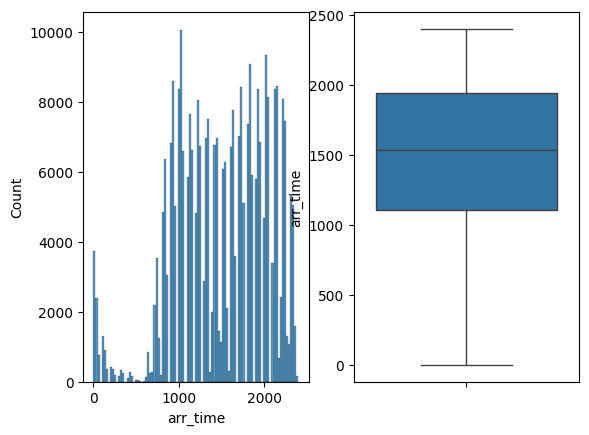

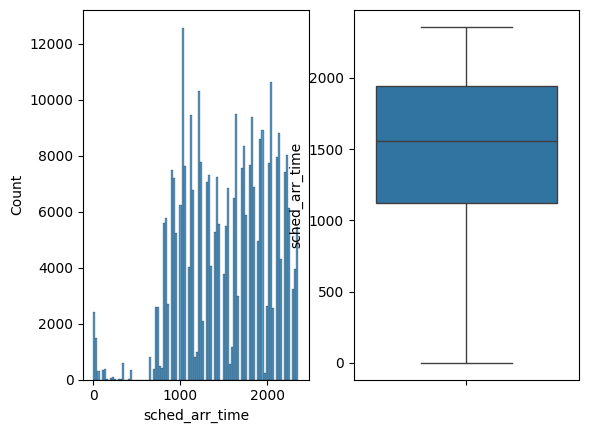

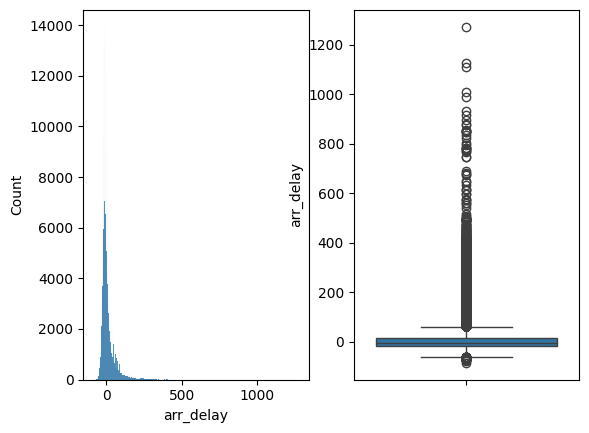

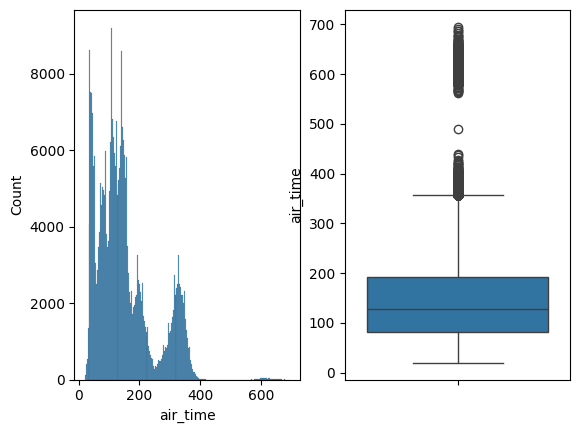

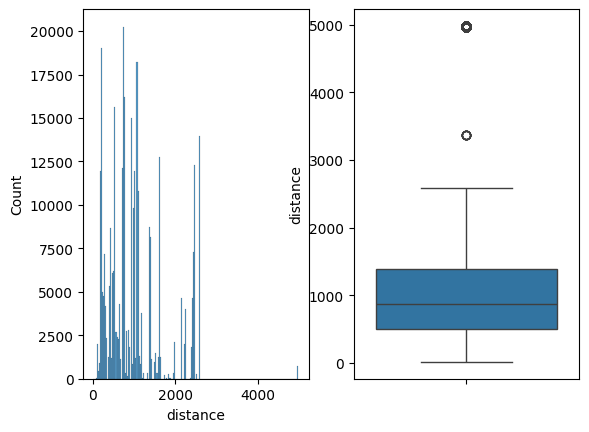

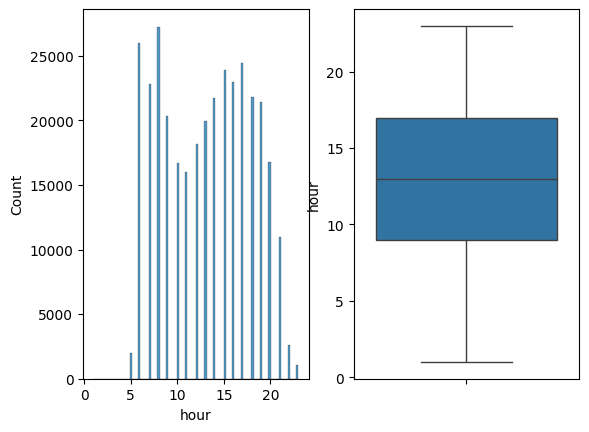

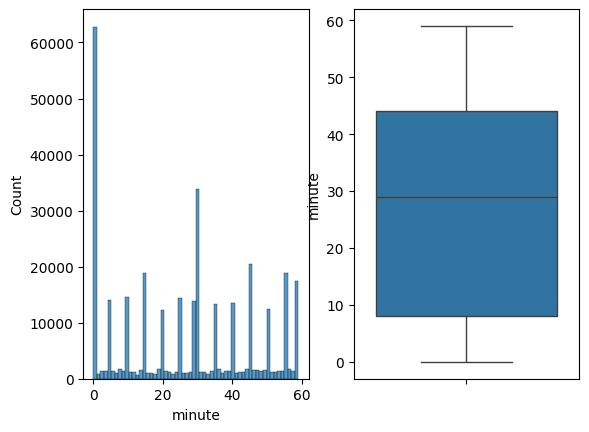

In [10]:
# uni-variate analysis
num_columns = df.select_dtypes(include="number").columns
for col in num_columns:
    fig, axes = plt.subplots(1, 2)
    sns.histplot(df[col], ax=axes[0])
    sns.boxplot(y=df[col], ax=axes[1])
    plt.show()

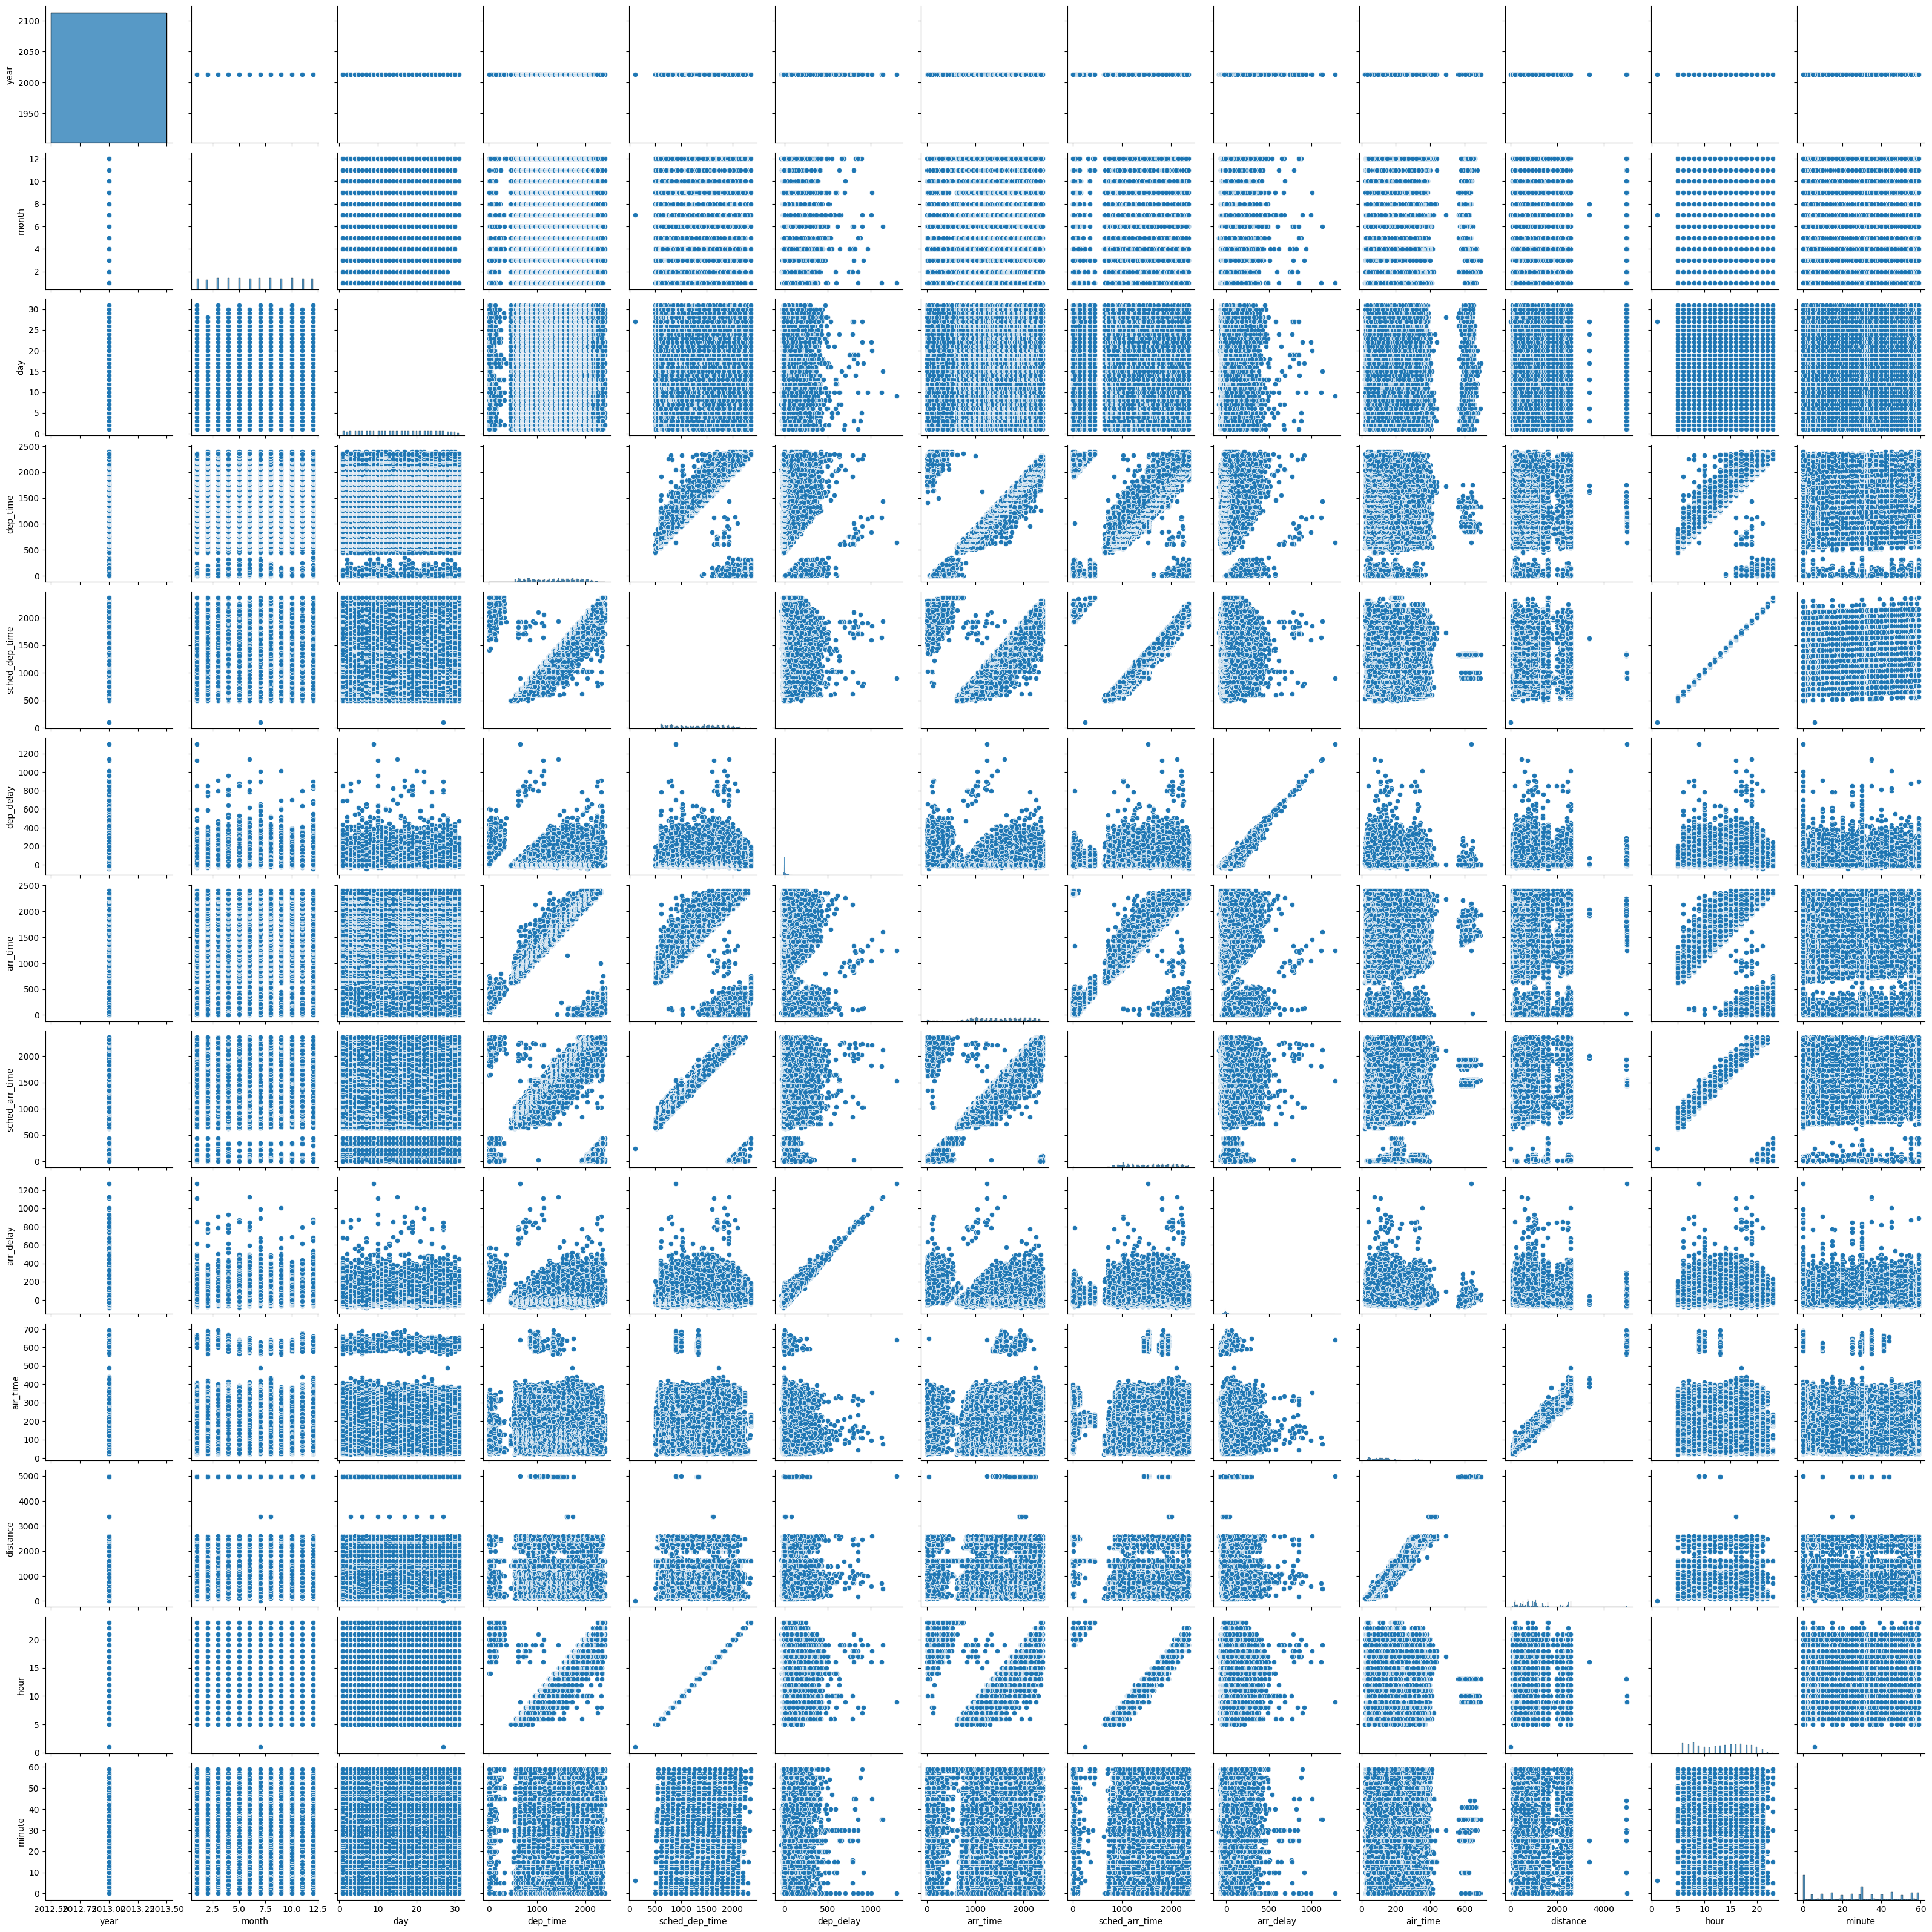

In [11]:
# multivaratie
sns.pairplot(df.select_dtypes('number'))

In [12]:
# Q1) Which carriers have the highest average arrival delay?
carrier_delay = df.groupby("carrier")["arr_delay"].mean().sort_values(ascending=False).head(10)
carrier_delay.round(2)

carrier
F9    21.92
FL    20.12
EV    15.80
YV    15.56
OO    11.93
MQ    10.77
WN     9.65
B6     9.46
9E     7.38
UA     3.56
Name: arr_delay, dtype: float64

In [13]:
top_n = 10
s = carrier_delay.dropna().sort_values(ascending=False).head(top_n)
df_plot = s.rename_axis('carrier').reset_index(name='avg_arr_delay')

fig = px.bar(
    df_plot,
    x='carrier',
    y='avg_arr_delay',
    color='avg_arr_delay',
    title='Top carriers by average arrival delay ',
    labels={'carrier':'Carrier', 'avg_arr_delay':'Avg arr_delay (min)'},
    text='avg_arr_delay'
)

# Keep your current order (descending) and polish hovers/labels
fig.update_xaxes(categoryorder='array', categoryarray=df_plot['carrier'])
fig.update_traces(
    texttemplate='%{y:.1f}',
    textposition='outside',
    hovertemplate='Carrier: %{x}<br>Avg delay: %{y:.2f} min'
)
fig.update_layout(yaxis=dict(title='Avg arr_delay (min)'), xaxis=dict(title='Carrier'), uniformtext_minsize=8, uniformtext_mode='hide')

fig.show()

In [14]:
# Q2) At what hours do departure delays spike?
hour_delay = df.groupby("hour")["dep_delay"].mean().sort_index()
hour_delay.round(2)

hour
1       NaN
5      0.69
6      1.64
7      1.91
8      4.13
9      4.58
10     6.50
11     7.19
12     8.61
13    11.44
14    13.82
15    16.89
16    18.76
17    21.10
18    21.11
19    24.78
20    24.30
21    24.20
22    18.79
23    14.02
Name: dep_delay, dtype: float64

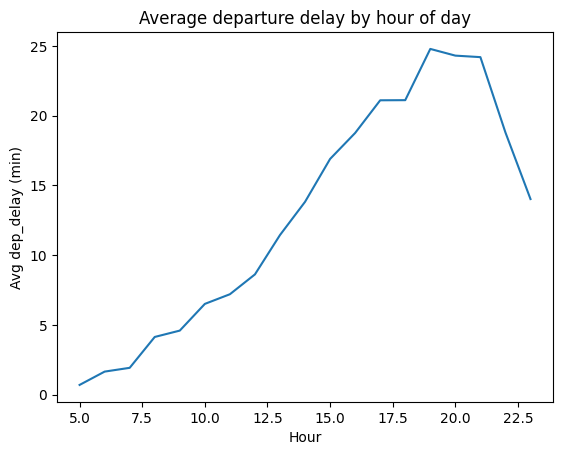

In [15]:
# Plot Q2) Avg dep_delay by hour
import matplotlib.pyplot as plt
plt.figure()
hour_delay.plot()
plt.title("Average departure delay by hour of day")
plt.xlabel("Hour"); plt.ylabel("Avg dep_delay (min)")
plt.show()

In [16]:
s = hour_delay.dropna()
df_plot = s.rename_axis('hour').reset_index(name='avg_dep_delay').sort_values('hour')

fig = px.line(
    df_plot,
    x='hour',
    y='avg_dep_delay',
    markers=True,
    
    title='Average departure delay by hour of day',
    labels={'hour': 'Hour', 'avg_dep_delay': 'Avg dep_delay (min)'}
)
fig.update_traces(hovertemplate='Hour: %{x}<br>Avg dep delay: %{y:.2f} min')
fig.update_xaxes(dtick=1)
fig.show()

In [17]:
# Q3) Which months have the worst arrival delays?
month_delay = df.groupby("month")["arr_delay"].mean().sort_index()
month_delay.round(2)

month
1      6.13
2      5.61
3      5.81
4     11.18
5      3.52
6     16.48
7     16.71
8      6.04
9     -4.02
10    -0.17
11     0.46
12    14.87
Name: arr_delay, dtype: float64

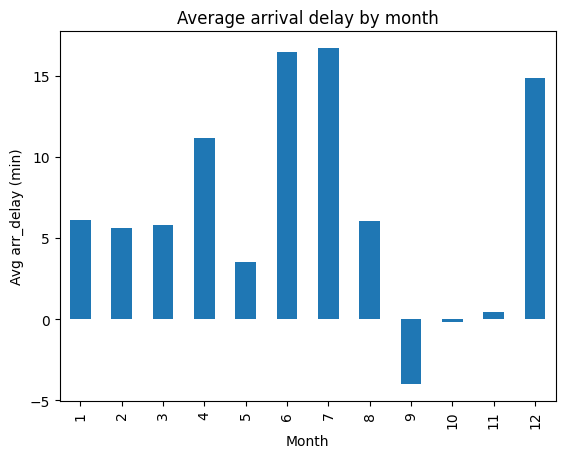

In [18]:
# Plot Q3) Avg arr_delay by month
import matplotlib.pyplot as plt
plt.figure()
month_delay.plot(kind="bar")
plt.title("Average arrival delay by month")
plt.xlabel("Month"); plt.ylabel("Avg arr_delay (min)")
plt.show()

In [19]:
s = month_delay.dropna()
df_plot = s.rename_axis('month').reset_index(name='avg_arr_delay').sort_values('month')
df_plot['month_name'] = pd.to_datetime(df_plot['month'], format='%m').dt.strftime('%b')

fig = px.bar(
    df_plot,
    x='month_name',
    y='avg_arr_delay',
    title='Average arrival delay by month (interactive)',
    labels={'month_name':'Month', 'avg_arr_delay':'Avg arr_delay (min)'},
    text='avg_arr_delay'
)
fig.update_traces(texttemplate='%{y:.1f}', textposition='outside',
                  hovertemplate='Month: %{x}<br>Avg arr delay: %{y:.2f} min')
fig.update_layout(xaxis={'categoryorder':'array','categoryarray':df_plot['month_name']})
fig.show()

In [20]:
# Q4) What is the cancellation rate overall and by carrier? (dep_time = NaN => canceled)
canceled = df["dep_time"].isna()
overall_cancel = float(canceled.mean())
cancel_by_carrier = df.groupby("carrier")["dep_time"].apply(lambda s: s.isna().mean()).sort_values(ascending=False)
print("Overall cancellation rate:", round(overall_cancel, 3))
cancel_by_carrier.round(3).head(10)

Overall cancellation rate: 0.025


carrier
OO    0.094
YV    0.093
9E    0.057
EV    0.052
MQ    0.047
US    0.032
FL    0.022
AA    0.019
WN    0.016
UA    0.012
Name: dep_time, dtype: float64

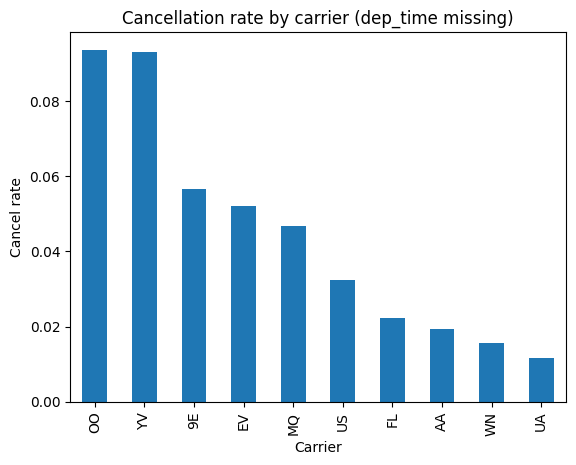

In [21]:
# Plot Q4) Cancellation rate by carrier (top 10)
import matplotlib.pyplot as plt
vals = cancel_by_carrier.head(10)
plt.figure()
vals.plot(kind="bar")
plt.title("Cancellation rate by carrier (dep_time missing)")
plt.xlabel("Carrier"); plt.ylabel("Cancel rate")
plt.show()

In [22]:
# Q5) What is the distribution of flights by month (1=January … 12=December)?

daily = (
    df.groupby(['year','month','day'])
      .size()
      .reset_index(name='flights')
)
daily['month_name'] = pd.to_datetime(daily['month'], format='%m').dt.strftime('%b')
daily.head()


year  month  day  flights month_name
0  2013      1    1      842        Jan
1  2013      1    2      943        Jan
2  2013      1    3      914        Jan
3  2013      1    4      915        Jan
4  2013      1    5      720        Jan

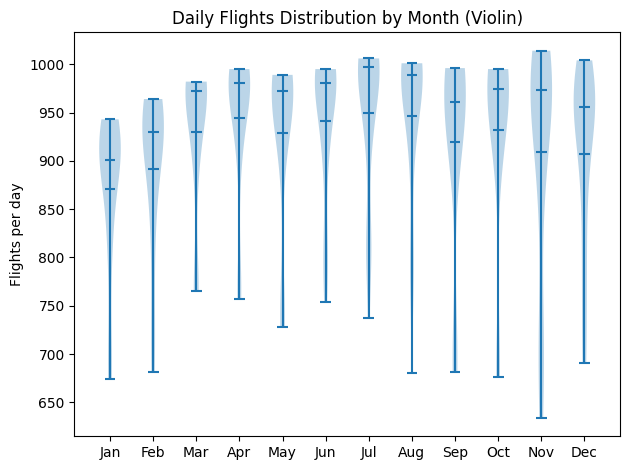

In [23]:

months = sorted(daily['month'].unique())
data = [daily.loc[daily['month']==m, 'flights'].values for m in months]
labels = [pd.to_datetime(m, format='%m').strftime('%b') for m in months]

plt.figure()
plt.violinplot(data, showmeans=True, showmedians=True)
plt.xticks(range(1, len(labels)+1), labels)
plt.title('Daily Flights Distribution by Month (Violin)')
plt.ylabel('Flights per day')
plt.tight_layout()
plt.show()

In [24]:
# Q6) Late-arrival rate by distance bucket
import pandas as pd
bins = [0, 300, 1000, 2000, 5000]
labels = ["short","medium","long","very long"]
dist_bucket = pd.cut(df["distance"], bins=bins, labels=labels, include_lowest=True)
late_rate_by_bucket = df.assign(dist_bucket=dist_bucket).groupby("dist_bucket")["arr_delay"].apply(lambda s: (s >= 15).mean())
late_rate_by_bucket.round(3)

C:\Users\khale\AppData\Local\Temp\ipykernel_7144\953895934.py:6: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



dist_bucket
short        0.237
medium       0.249
long         0.236
very long    0.215
Name: arr_delay, dtype: float64

In [25]:
# PIE: Share of late arrivals (>=15 min) by distance bucket (interactive)
# Requires: pip install plotly

import pandas as pd
import plotly.express as px

# Recreate buckets (safe even if you already defined them)
bins   = [0, 300, 1000, 2000, 5000]
labels = ["short","medium","long","very long"]

tmp = df.assign(
    dist_bucket = pd.cut(df["distance"], bins=bins, labels=labels, include_lowest=True)
)

# Count late flights and totals per bucket
df_plot = (
    tmp.groupby("dist_bucket", dropna=True)["arr_delay"]
      .agg(flights="size", late_flights=lambda s: (s >= 15).sum())
      .reset_index()
)
df_plot["late_rate"] = (df_plot["late_flights"] / df_plot["flights"] * 100).round(2)

# Interactive donut pie by *late flights* (more meaningful than rates for pie slices)
fig = px.pie(
    df_plot,
    names="dist_bucket",
    values="late_flights",
    hole=0.45,
    title="Share of Late Arrivals (≥15 min) by Distance Bucket"
)
fig.update_traces(
    textinfo="percent+label",
    hovertemplate=(
        "Bucket: %{label}<br>"
        "Late flights: %{value}<br>"
        "All flights: %{customdata[0]}<br>"
        "Late rate: %{customdata[1]}%"
    ),
    customdata=df_plot[["flights","late_rate"]].to_numpy()
)
fig.update_layout(showlegend=True)
fig.show()


C:\Users\khale\AppData\Local\Temp\ipykernel_7144\2527110086.py:17: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



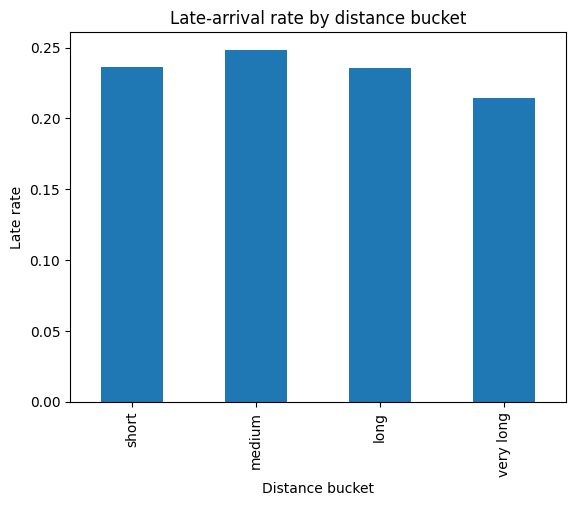

In [26]:
# Plot Q6) Late rate by distance bucket
import matplotlib.pyplot as plt
vals = late_rate_by_bucket
plt.figure()
vals.plot(kind="bar")
plt.title("Late-arrival rate by distance bucket")
plt.xlabel("Distance bucket"); plt.ylabel("Late rate")
plt.show()

In [27]:
# Q7) Do certain weekdays have worse arrival delays?
import pandas as pd
dates = pd.to_datetime(dict(year=df["year"], month=df["month"], day=df["day"]), errors="coerce")
weekday = dates.dt.weekday  # 0=Mon ... 6=Sun
weekday_delay = pd.Series(df["arr_delay"].values).groupby(weekday).mean()
weekday_delay.index = ["Mon","Tue","Wed","Thu","Fri","Sat","Sun"]
weekday_delay.round(2)

Mon     9.65
Tue     5.39
Wed     7.05
Thu    11.74
Fri     9.07
Sat    -1.45
Sun     4.82
dtype: float64

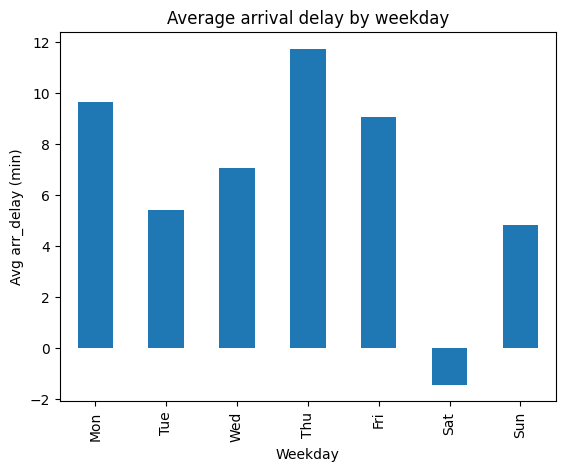

In [28]:
# Plot Q7) Avg arr_delay by weekday
import matplotlib.pyplot as plt
plt.figure()
weekday_delay.plot(kind="bar")
plt.title("Average arrival delay by weekday")
plt.xlabel("Weekday"); plt.ylabel("Avg arr_delay (min)")
plt.show()

In [29]:
# Q8) Which destinations have most traffic? (top 10 by flight count)
top_dest = df["dest"].value_counts().head(10)
top_dest

dest
ORD    17283
ATL    17215
LAX    16174
BOS    15508
MCO    14082
CLT    14064
SFO    13331
FLL    12055
MIA    11728
DCA     9705
Name: count, dtype: int64

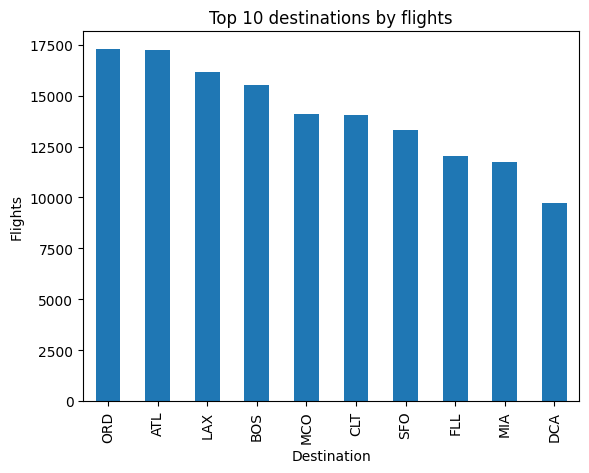

In [30]:
# Plot Q8) Top 10 destinations by flight count
import matplotlib.pyplot as plt
plt.figure()
top_dest.plot(kind="bar")
plt.title("Top 10 destinations by flights")
plt.xlabel("Destination"); plt.ylabel("Flights")
plt.show()

In [31]:
# Q9) Do departure delays propagate into arrival delays? (corr + simple view)
corr_da = df[["dep_delay","arr_delay"]].corr().iloc[0,1]
print("Correlation dep_delay vs arr_delay:", round(float(corr_da), 3))

Correlation dep_delay vs arr_delay: 0.915


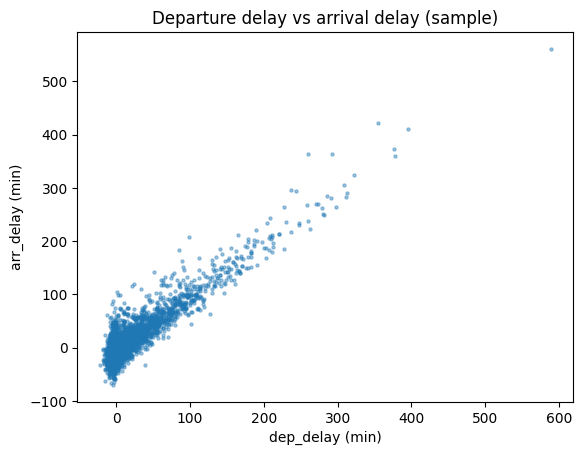

In [32]:
# Plot Q9) Scatter dep_delay vs arr_delay (sample)
import matplotlib.pyplot as plt
sample = df[["dep_delay","arr_delay"]].dropna().sample(n=min(5000, len(df)), random_state=7)
plt.figure()
plt.scatter(sample["dep_delay"], sample["arr_delay"], s=5, alpha=0.4)
plt.title("Departure delay vs arrival delay (sample)")
plt.xlabel("dep_delay (min)"); plt.ylabel("arr_delay (min)")
plt.show()

In [33]:
#Q10) Which airlines have the highest number of flights?.
# 1) Pick the column to count (prefer 'name', else use 'carrier')
col = 'name' if 'name' in df.columns else 'carrier'

# 2) Count flights per airline and show the top 10
top_n = 10
counts = df[col].value_counts().head(top_n)
print(counts)


name
United Air Lines Inc.       58665
JetBlue Airways             54635
ExpressJet Airlines Inc.    54173
Delta Air Lines Inc.        48110
American Airlines Inc.      32729
Envoy Air                   26397
US Airways Inc.             20536
Endeavor Air Inc.           18460
Southwest Airlines Co.      12275
Virgin America               5162
Name: count, dtype: int64


In [34]:
import plotly.express as px
counts = (
    df[col]
    .dropna()
    .value_counts()
    .head(10)
    .rename_axis('airline')
    .reset_index(name='flights')
)

fig = px.pie(
    counts,
    names='airline',     # <-- now a real column
    values='flights',    # <-- numeric values column
    hole=0.45,
    title='Top Airlines by Number of Flights '
)
fig.update_traces(textinfo='percent+label',
                  hovertemplate='%{label}<br>Flights: %{value}<br>%{percent}')
fig.show()

### 3) Pre-Processing Mind Map:


In [35]:
df.duplicated().sum()

np.int64(0)

In [36]:
df.drop_duplicates(inplace=True)

In [37]:
# Train/test split for the NYC flights columns you listed
# Target: predict arrival delay in minutes (arr_delay) → regression setup

from sklearn.model_selection import train_test_split
import pandas as pd

# 1) Drop rows with missing target to avoid teaching the model on imputed targets
df_ = df.dropna(subset=['arr_delay']).copy()

# 2) Define X (features) and y (target)
#    - Drop target itself
#    - Drop columns that would leak the answer or are IDs:
#        • 'arr_time' = actual arrival time (known only after flight ends) → leakage
#        • 'id' = record identifier, not predictive
#        • 'time_hour' is a timestamp string/obj; we’ll drop it here for simplicity
drop_cols = ['arr_delay', 'arr_time', 'id', 'time_hour']  # keep sched_dep_time/sched_arr_time if you want
X = df_.drop(columns=drop_cols, errors='ignore')
y = df_['arr_delay']

# 3) Split (80/20); no stratify because y is continuous
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)

X_train.shape, X_test.shape, y_train.shape, y_test.shape


((261876, 17), (65470, 17), (261876,), (65470,))

Drop the rows or columns with missing data, especially if the percentage of missing data is very high.
Fill the missing data with a central tendency measure (mean, median, or mode).

In [38]:
df.isnull().mean()

id                0.000000
year              0.000000
month             0.000000
day               0.000000
dep_time          0.024512
sched_dep_time    0.000000
dep_delay         0.024512
arr_time          0.025872
sched_arr_time    0.000000
arr_delay         0.028001
carrier           0.000000
flight            0.000000
tailnum           0.007459
origin            0.000000
dest              0.000000
air_time          0.028001
distance          0.000000
hour              0.000000
minute            0.000000
time_hour         0.000000
name              0.000000
dtype: float64

In [39]:
missing_percent = df.isnull().mean().sort_values(ascending=False) * 100
print("Missing Value Percentage by Columns:\n", round(missing_percent,2))

Missing Value Percentage by Columns:
 arr_delay         2.80
air_time          2.80
arr_time          2.59
dep_delay         2.45
dep_time          2.45
tailnum           0.75
month             0.00
year              0.00
id                0.00
day               0.00
sched_arr_time    0.00
carrier           0.00
sched_dep_time    0.00
flight            0.00
origin            0.00
dest              0.00
distance          0.00
hour              0.00
minute            0.00
time_hour         0.00
name              0.00
dtype: float64


In [40]:
from sklearn.impute import SimpleImputer
import pandas as pd

num_cols = [
    'dep_delay','air_time','distance',
    'sched_dep_time','sched_arr_time','hour','minute',
    
]
num_cols = [c for c in num_cols if c in X_train.columns]

cat_cols = [
    'carrier','flight','tailnum','origin','dest','name'
]
cat_cols = [c for c in cat_cols if c in X_train.columns]

# 1) Numeric → median
median_imputer = SimpleImputer(strategy='median')
X_train.loc[:, num_cols] = median_imputer.fit_transform(X_train[num_cols])
X_test.loc[:,  num_cols] = median_imputer.transform(X_test[num_cols])

# 2) Categorical → most_frequent
mode_imputer = SimpleImputer(strategy='most_frequent')
X_train.loc[:, cat_cols] = mode_imputer.fit_transform(X_train[cat_cols])
X_test.loc[:,  cat_cols] = mode_imputer.transform(X_test[cat_cols])

# 3) Type casting
for c in ['hour','minute','sched_dep_time','sched_arr_time','distance']:
    if c in X_train.columns:
        X_train.loc[:, c] = X_train[c].astype(int)
        X_test.loc[:,  c] = X_test[c].astype(int)


In [41]:
X_train.isna().sum()

year              0
month             0
day               0
dep_time          0
sched_dep_time    0
dep_delay         0
sched_arr_time    0
carrier           0
flight            0
tailnum           0
origin            0
dest              0
air_time          0
distance          0
hour              0
minute            0
name              0
dtype: int64

In [42]:
# Count outliers per numeric column using IQR (on X_train)
import pandas as pd

num = X_train.select_dtypes(include=['number','Float64','Int64'])
Q1, Q3 = num.quantile(0.25), num.quantile(0.75)
IQR = Q3 - Q1
lower, upper = Q1 - 1.5*IQR, Q3 + 1.5*IQR

out_counts = ((num < lower) | (num > upper)).sum().sort_values(ascending=False)
(out_counts.to_frame('outliers')
          .assign(pct=lambda d: (d['outliers'] / len(num) * 100).round(2)))


outliers    pct
dep_delay          34220  13.07
air_time            4379   1.67
distance             559   0.21
day                    0   0.00
month                  0   0.00
year                   0   0.00
dep_time               0   0.00
sched_arr_time         0   0.00
sched_dep_time         0   0.00
hour                   0   0.00
minute                 0   0.00

In [43]:
X_train = X_train.drop(columns=['dep_delay'], errors='ignore')
X_test  = X_test.drop(columns=['dep_delay'],  errors='ignore')


<Axes: xlabel='distance'>

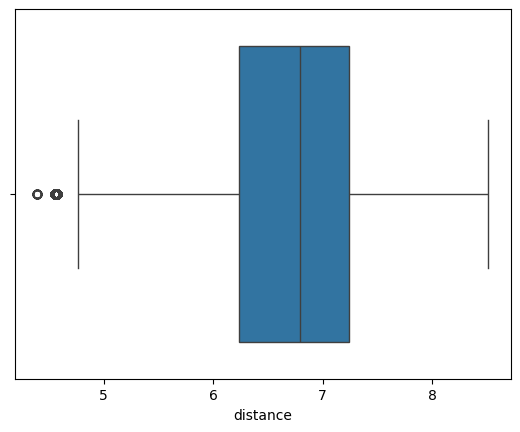

In [44]:
X_train[['distance','air_time']], X_test[['distance','air_time']] = np.log1p(X_train[['distance','air_time']].clip(lower=0)), np.log1p(X_test[['distance','air_time']].clip(lower=0))
sns.boxplot(x=X_train['distance'])


<Axes: xlabel='distance', ylabel='Count'>

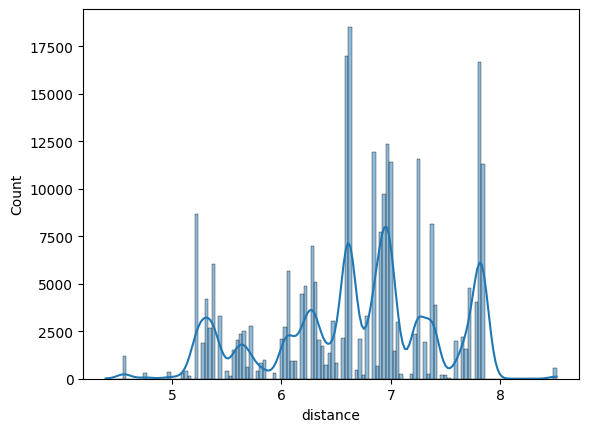

In [45]:
sns.histplot(X_train['distance'], kde=True)

In [46]:
#  ENCODING RULES & STEPS (PROJECT STANDARD)
# Goal: Convert categorical features to numeric WITHOUT leakage, following our fixed rule:
#   • Nominal features  → if unique categories ≤ 7  → One-Hot Encoding
#                         if unique categories  > 7 → Binary Encoding
#
# Why:
#   - One-Hot is simple/faithful for small-cardinality features.
#   - Binary Encoding compresses high-cardinality features to fewer columns (vs massive One-Hot).
#
# Dataset-specific notes (NYC Flights):
#   - low-card nominal (One-Hot): origin  (≈ 3)
#   - high-card nominal (Binary): carrier (≈16), name (≈16), dest (≈104), flight (≈3.7k), tailnum (≈4k)
#   - DO NOT encode target or leakage columns (e.g., arr_delay target; avoid arr_time/time_hour if not intended).


In [47]:
# * e) Encoding: (Ordinal:[OrdinalEncoder, LabelEncoder] - Nominal: [< 7 uniques(OneHotEncoding), > 7 uniques (BinaryEncoder)])
cat_cols = X_train.select_dtypes("O").columns
for col in cat_cols:
    print(col, X_train[col].nunique())

carrier 16
flight 3758
tailnum 3998
origin 3
dest 104
name 16


In [48]:
bin_encoder = BinaryEncoder()
train_cat_encoded = bin_encoder.fit_transform(X_train[cat_cols])
X_train_encoded = pd.concat([X_train, train_cat_encoded], axis=1)
X_train_encoded.drop(cat_cols, axis=1, inplace=True)

test_cat_encoded = bin_encoder.transform(X_test[cat_cols])
X_test_encoded = pd.concat([X_test, test_cat_encoded], axis=1)
X_test_encoded.drop(cat_cols, axis=1, inplace=True)

In [49]:
X_train_encoded

year  month  day  dep_time  sched_dep_time  sched_arr_time  air_time  \
17752   2013      1   21    1352.0            1359            1534  4.875197   
313100  2013      9    5    1101.0            1105            1215  3.912023   
126586  2013      2   18    1509.0            1509            1708  4.532599   
201277  2013      5    9    1219.0            1220            1415  4.356709   
102571  2013     12   21    2229.0            2129              22  4.934474   
...      ...    ...  ...       ...             ...             ...       ...   
123263  2013      2   14    1727.0            1725            1827  3.637586   
266954  2013      7   18    1525.0            1520            1814  5.686975   
135550  2013      2   28     953.0            1000            1209  4.430817   
151158  2013      3   17     728.0             732             849  3.555348   
125357  2013      2   17     842.0             829            1103  4.804021   

        distance  hour  minute  ...  dest_2  dest_3  dest_4  dest_5  dest_6  \
17752   6.579251    13      59  ...       0       0       0       0       1   
313100  5.365976    11       5  ...       0       0       0       1       0   
126586  6.388561    15       9  ...       0       0       0       1       1   
201277  6.192362    12      20  ...       0       0       1       0       0   
102571  6.931472    21      29  ...       0       0       1       0       1   
...          ...   ...     ...  ...     ...     ...     ...     ...     ...   
123263  5.135798    17      25  ...       0       0       0       0       0   
266954  7.805882    15      20  ...       0       1       0       1       0   
135550  6.300786    10       0  ...       1       0       1       1       1   
151158  5.303305     7      32  ...       1       0       0       0       1   
125357  6.720220     8      29  ...       1       1       1       1       0   

        name_0  name_1  name_2  name_3  name_4  
17752        0       0       0       0       1  
313100       0       0       0       1       0  
126586       0       0       0       1       1  
201277       0       0       0       1       1  
102571       0       0       1       0       0  
...        ...     ...     ...     ...     ...  
123263       0       0       0       1       1  
266954       0       0       0       0       1  
135550       0       1       0       0       1  
151158       0       0       0       1       1  
125357       0       0       1       0       0  

[261876 rows x 53 columns]

In [50]:
X_train_encoded.describe()

year          month            day       dep_time  sched_dep_time  \
count  261876.0  261876.000000  261876.000000  261876.000000   261876.000000   
mean     2013.0       6.567268      15.741832    1348.384445     1340.153107   
std         0.0       3.413388       8.777156     488.144630      467.178975   
min      2013.0       1.000000       1.000000       1.000000      500.000000   
25%      2013.0       4.000000       8.000000     907.000000      905.000000   
50%      2013.0       7.000000      16.000000    1359.000000     1355.000000   
75%      2013.0      10.000000      23.000000    1744.000000     1729.000000   
max      2013.0      12.000000      31.000000    2400.000000     2359.000000   

       sched_arr_time       air_time       distance           hour  \
count   261876.000000  261876.000000  261876.000000  261876.000000   
mean      1532.653435       4.831580       6.692920      13.139348   
std        497.668977       0.635024       0.769423       4.659502   
min          1.000000       3.044522       4.394449       5.000000   
25%       1122.000000       4.418841       6.234411       9.000000   
50%       1554.000000       4.867534       6.790097      13.000000   
75%       1944.000000       5.262690       7.238497      17.000000   
max       2359.000000       6.545350       8.513988      23.000000   

              minute  ...         dest_2        dest_3         dest_4  \
count  261876.000000  ...  261876.000000  261876.00000  261876.000000   
mean       26.218267  ...       0.400380       0.43411       0.512758   
std        19.300385  ...       0.489976       0.49564       0.499838   
min         0.000000  ...       0.000000       0.00000       0.000000   
25%         8.000000  ...       0.000000       0.00000       0.000000   
50%        29.000000  ...       0.000000       0.00000       1.000000   
75%        44.000000  ...       1.000000       1.00000       1.000000   
max        59.000000  ...       1.000000       1.00000       1.000000   

              dest_5         dest_6         name_0         name_1  \
count  261876.000000  261876.000000  261876.000000  261876.000000   
mean        0.530854       0.535818       0.000095       0.167247   
std         0.499048       0.498716       0.009770       0.373197   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       0.000000       0.000000       0.000000   
50%         1.000000       1.000000       0.000000       0.000000   
75%         1.000000       1.000000       0.000000       0.000000   
max         1.000000       1.000000       1.000000       1.000000   

              name_2         name_3         name_4  
count  261876.000000  261876.000000  261876.000000  
mean        0.438437       0.403527       0.649930  
std         0.496196       0.490606       0.476993  
min         0.000000       0.000000       0.000000  
25%         0.000000       0.000000       0.000000  
50%         0.000000       0.000000       1.000000  
75%         1.000000       1.000000       1.000000  
max         1.000000       1.000000       1.000000  

[8 rows x 53 columns]

In [51]:
X_train_encoded.to_csv("train_cleaned_encoded.csv", index=False)
X_test_encoded.to_csv("test_cleaned_encoded.csv", index=False)

In [52]:
# encoders.py — simple Binary Encoder (NumPy + sklearn API)
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin

class BinEnc(BaseEstimator, TransformerMixin):
    def __init__(self): self.maps_, self.bits_ = [], []
    def fit(self, X, y=None):
        X = np.asarray(X, dtype=object)
        self.maps_.clear(); self.bits_.clear()
        for j in range(X.shape[1]):
            u = np.unique(X[:, j].astype(str))
            self.maps_.append({v: i+1 for i, v in enumerate(u)})   # 1..N (0 = unknown)
            self.bits_.append(max(1, int(np.ceil(np.log2(len(u)+1)))))
        return self
    def transform(self, X):
        X = np.asarray(X, dtype=object); outs = []
        for j, (m, b) in enumerate(zip(self.maps_, self.bits_)):
            c = np.array([m.get(v, 0) for v in X[:, j].astype(str)], dtype=np.int64)
            outs.append(np.column_stack([((c >> t) & 1).astype(np.float32) for t in range(b)]))
        return np.hstack(outs) if outs else np.empty((len(X), 0), dtype=np.float32)


In [53]:
!pip install streamlit

In [54]:
import streamlit as st

st.pyplot()

2025-08-16 00:37:18.117 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-16 00:37:19.088 
  command:

    streamlit run C:\Users\khale\AppData\Roaming\Python\Python313\site-packages\ipykernel_launcher.py [ARGUMENTS]
2025-08-16 00:37:19.088 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-16 00:37:19.089 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-16 00:37:19.089 
Calling `st.pyplot()` without providing a figure argument has been deprecated
and will be removed in a later version as it requires the use of Matplotlib's
global figure object, which is not thread-safe.

To future-proof this code, you should pass in a figure as shown below:

```python
fig, ax = plt.subplots()
ax.scatter([1, 2, 3], [1, 2, 3])
# other plotting actions...
st.pyplot(fig)
```

If you have a specific use case that requires this fu

DeltaGenerator()

In [55]:
from pathlib import Path
base = Path(r"yomna's final project")
(base / "pages").mkdir(parents=True, exist_ok=True)

( base / "pages" / "1_Overview.py" ).write_text("print('Overview OK')", encoding="utf-8")


20

In [56]:
%%writefile "yomna's final project/pages_1_Overview.py"
import streamlit as st
import pandas as pd
import numpy as np
from pathlib import Path

st.set_page_config(page_title="NYC Flights — Overview", page_icon="✈️", layout="wide")
st.title("✈️ NYC Flights — Overview & Insights")

# ✅ مصدر البيانات (Kaggle)
st.markdown(
    "Data source: **Kaggle** — "
    "[Flights (NYC 2025)](https://www.kaggle.com/datasets/mahoora00135/flights/data)"
)

st.caption("Before-departure only (no leakage) • origin→One-Hot • carrier/dest→Binary • HHMM→minutes")


DATA_PATH = Path(r"Flights export 2025.csv") 
@st.cache_data(show_spinner=False)
def load_df(path: Path) -> pd.DataFrame:
    if not path.exists():
        st.error(f"CSV not found at: {path.resolve()}")
        st.stop()
    df = pd.read_csv(path)
    # مشتقات بسيطة للعرض
    if "month" in df.columns:
        df["month_str"] = df["month"].astype(str)
    return df

df = load_df(DATA_PATH)

# لمحة سريعة
c1, c2, c3 = st.columns(3)
c1.metric("Rows", f"{len(df):,}")
c2.metric("Columns", f"{df.shape[1]}")
c3.metric("Any NaN cols", f"{df.isna().any().sum()}")

with st.expander("👀 Data preview (first 50 rows)", expanded=False):
    st.dataframe(df.head(50), use_container_width=True)

with st.expander("🧼 Missing values (%) by column", expanded=False):
    mv = (df.isna().mean()*100).round(2).sort_values(ascending=False)
    st.dataframe(mv.to_frame("missing_%"), use_container_width=True)

st.markdown("---")
st.caption("Insights & modeling use only **pre-departure** features to avoid leakage.")


Overwriting yomna's final project/pages_1_Overview.py


In [57]:
%%writefile "yomna's final project/pages_2_Dashboard.py"
import streamlit as st
import pandas as pd
import numpy as np
import plotly.express as px
from pathlib import Path

# -------------------- Page setup --------------------
st.set_page_config(page_title="NYC Flights — Dashboard", page_icon="📊", layout="wide")
st.title("📊 NYC Flights — Interactive Dashboard")

# -------------------- Data loading --------------------
DATA_PATH = Path(r"Flights export 2025.csv")  # عدّلي المسار لو لزم
if not DATA_PATH.exists():
    st.error(f"CSV not found at: {DATA_PATH.resolve()}")
    st.stop()

@st.cache_data(show_spinner=False)
def load_df(path: Path) -> pd.DataFrame:
    df = pd.read_csv(path)
    df.columns = [c.strip().lower() for c in df.columns]
    rename_map = {
        "dayofmonth": "day", "day_of_month": "day",
        "arrdelay": "arr_delay", "depdelay": "dep_delay",
        "carriername": "carrier", "carrier_name": "carrier",
        "origin_airport": "origin", "dest_airport": "dest",
        "originairportid": "origin", "destairportid": "dest",
    }
    df.rename(columns={k: v for k, v in rename_map.items() if k in df.columns}, inplace=True)
    for c in ["year","month","day","hour","minute","arr_delay","dep_delay","distance","air_time"]:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")
    return df

df_main = load_df(DATA_PATH)
palette = px.colors.qualitative.Set2

# -------------------- Helpers --------------------
def apply_filters(d: pd.DataFrame, months_sel, days_sel, extra_filter):
    if not isinstance(d, pd.DataFrame):
        st.error(f"Internal error: expected DataFrame, got {type(d).__name__}.")
        st.stop()
    out = d.copy()
    if "month" in out.columns and months_sel:
        out = out[out["month"].isin(months_sel)]
    if "day" in out.columns and days_sel:
        out = out[out["day"].isin(days_sel)]
    if extra_filter is not None:
        col, vals = extra_filter
        if col in out.columns and vals:
            out = out[out[col].astype(str).isin([str(v) for v in vals])]
    return out

months_all = sorted(df_main["month"].dropna().unique()) if "month" in df_main else []
days_all   = sorted(df_main["day"].dropna().unique())   if "day"   in df_main else []
car_all    = sorted(df_main["carrier"].dropna().unique()) if "carrier" in df_main else []
org_all    = sorted(df_main["origin"].dropna().unique())  if "origin"  in df_main else []

# ==================== Chart 1 ====================
st.subheader("Q1) Which carriers have higher arrival delays?")
fc1a, fc1b, fc1c = st.columns(3)
m1 = fc1a.multiselect("Filter: Months", months_all, default=months_all, key="c1_months") if months_all else []
d1 = fc1b.multiselect("Filter: Days",   days_all,   default=days_all,   key="c1_days")   if days_all   else []
c1 = fc1c.multiselect("Filter: Carrier", car_all,   default=car_all,   key="c1_car")    if car_all    else []
dff1 = apply_filters(df_main, m1, d1, ("carrier", c1) if c1 else None)

if {"carrier","arr_delay"}.issubset(dff1.columns) and len(dff1):
    fig1 = px.box(
        dff1, x="carrier", y="arr_delay", points="outliers",
        labels={"carrier": "Carrier", "arr_delay": "Arrival delay (min)"},
        color="carrier", color_discrete_sequence=palette,
        title="Arrival delay by carrier"
    )
    st.plotly_chart(fig1, use_container_width=True)
else:
    st.info("Required columns not found: carrier, arr_delay")

st.markdown("---")

# ==================== Chart 2 ====================
st.subheader("Q2) When (hour) do departures face the most delay?")
fc2a, fc2b, fc2c = st.columns(3)
m2 = fc2a.multiselect("Filter: Months", months_all, default=months_all, key="c2_months") if months_all else []
d2 = fc2b.multiselect("Filter: Days",   days_all,   default=days_all,   key="c2_days")   if days_all   else []
o2 = fc2c.multiselect("Filter: Origin", org_all,    default=org_all,    key="c2_org")    if org_all    else []
dff2 = apply_filters(df_main, m2, d2, ("origin", o2) if o2 else None)

if {"hour","dep_delay"}.issubset(dff2.columns) and len(dff2):
    g2 = dff2.groupby("hour", as_index=False)["dep_delay"].mean()
    fig2 = px.line(
        g2, x="hour", y="dep_delay", markers=True,
        labels={"hour": "Hour of day (0–23)", "dep_delay": "Avg departure delay (min)"},
        title="Average departure delay by hour"
    )
    st.plotly_chart(fig2, use_container_width=True)
else:
    st.info("Required columns not found: hour, dep_delay")

st.markdown("---")

# ==================== Chart 3 ====================
st.subheader("Q3) What is the distribution of flight distances?")
fc3a, fc3b = st.columns(2)
m3 = fc3a.multiselect("Filter: Months", months_all, default=months_all, key="c3_months") if months_all else []
d3 = fc3b.multiselect("Filter: Days",   days_all,   default=days_all,   key="c3_days")   if days_all   else []
dff3 = apply_filters(df_main, m3, d3, None)

if "distance" in dff3.columns and len(dff3):
    fig3 = px.histogram(
        dff3, x="distance", nbins=60,
        labels={"distance": "Distance (miles)"},
        title="Distribution of distance (miles)"
    )
    st.plotly_chart(fig3, use_container_width=True)
else:
    st.info("Required column not found: distance")

st.markdown("---")

# ==================== Chart 4 ====================
st.subheader("Q4) How does distance relate to arrival delay?")
fc4a, fc4b, fc4c = st.columns(3)
m4 = fc4a.multiselect("Filter: Months", months_all, default=months_all, key="c4_months") if months_all else []
d4 = fc4b.multiselect("Filter: Days",   days_all,   default=days_all,   key="c4_days")   if days_all   else []
c4 = fc4c.multiselect("Filter: Carrier", car_all,   default=car_all,   key="c4_car")    if car_all    else []
dff4 = apply_filters(df_main, m4, d4, ("carrier", c4) if c4 else None)

if {"distance","arr_delay"}.issubset(dff4.columns) and len(dff4):
    color_series = dff4["carrier"].astype(str) if "carrier" in dff4.columns else None
    fig4 = px.scatter(
        dff4, x="distance", y="arr_delay", color=color_series, opacity=0.6,
        labels={"distance": "Distance (miles)", "arr_delay": "Arrival delay (min)", "color": "Carrier"},
        title="Arrival delay vs distance",
        color_discrete_sequence=palette
    )
    st.plotly_chart(fig4, use_container_width=True)
else:
    st.info("Required columns not found: distance, arr_delay")

st.markdown("---")

# ==================== Chart 5 ====================
st.subheader("Q5) Which months have the highest late-arrival rate?")
fc5a, fc5b, fc5c = st.columns(3)
m5 = fc5a.multiselect("Filter: Months", months_all, default=months_all, key="c5_months") if months_all else []
d5 = fc5b.multiselect("Filter: Days",   days_all,   default=days_all,   key="c5_days")   if days_all   else []
c5 = fc5c.multiselect("Filter: Carrier", car_all,   default=car_all,   key="c5_car")    if car_all    else []
dff5 = apply_filters(df_main, m5, d5, ("carrier", c5) if c5 else None)

if {"month","arr_delay"}.issubset(dff5.columns) and len(dff5):
    g5 = dff5.assign(is_late = dff5["arr_delay"] >= 15).groupby("month", as_index=False)["is_late"].mean()
    g5["late_rate_pct"] = (g5["is_late"] * 100).round(1)
    fig5 = px.bar(
        g5, x="month", y="late_rate_pct",
        labels={"month": "Month (1–12)", "late_rate_pct": "Late rate (%)"},
        title="Late-arrival rate by month (%)",
        color_discrete_sequence=palette
    )
    st.plotly_chart(fig5, use_container_width=True)
else:
    st.info("Required columns not found: month, arr_delay")


Overwriting yomna's final project/pages_2_Dashboard.py
